In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [93]:
grid_path = "/home/william/Codes/cybath/data/grid_map/costmap_f3.png"
grid_fig = plt.imread(grid_path, 'png') # for some reason, matplotlib returns a float matrix for .png
grid_fig = (grid_fig * 255).astype(np.uint8)

In [94]:
indices = np.where(grid_fig == 254)
walkable_mask = np.zeros_like(grid_fig)
walkable_mask[indices] = 1
walkable_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
import random


class Node:
    def __init__(self, position, parent=None):
        self.position = position
        self.parent = parent
        self.g = 0
        self.h = 0
        self.f = 0

    def __lt__(self, other):
        return self.f < other.f

def heuristic(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def get_neighbors(node, grid):
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        x, y = node.position[0] + dx, node.position[1] + dy
        if 0 <= x < grid.shape[0] and 0 <= y < grid.shape[1] and grid[x, y] == 1:
            neighbors.append((x, y))
    return neighbors

def a_star(start, goal, grid):
    start_node = Node(start)
    goal_node = Node(goal)
    open_list = []
    closed_list = set()
    heapq.heappush(open_list, start_node)

    while open_list:
        current_node = heapq.heappop(open_list)
        closed_list.add(current_node.position)

        if current_node.position == goal_node.position:
            path = []
            while current_node:
                path.append(current_node.position)
                current_node = current_node.parent
            return path[::-1]

        for neighbor_pos in get_neighbors(current_node, grid):
            if neighbor_pos in closed_list:
                continue

            neighbor_node = Node(neighbor_pos, current_node)
            neighbor_node.g = current_node.g + 1
            neighbor_node.h = heuristic(neighbor_node.position, goal_node.position)
            neighbor_node.f = neighbor_node.g + neighbor_node.h

            if any(open_node.position == neighbor_node.position and open_node.f <= neighbor_node.f for open_node in open_list):
                continue

            heapq.heappush(open_list, neighbor_node)

    return None

def create_occupancy_grid(size, obstacle_percentage=0.2):
    grid = np.zeros(size)
    
    # Randomly place obstacles
    num_obstacles = int(obstacle_percentage * size[0] * size[1])
    obstacle_indices = random.sample(range(size[0] * size[1]), num_obstacles)
    
    for idx in obstacle_indices:
        x, y = divmod(idx, size[1])
        grid[x, y] = 1
    
    return grid

def ensure_path(grid, start, goal):
    # Create a simple path from start to goal
    x0, y0 = start
    x1, y1 = goal
    grid[x0, y0] = 1
    grid[x1, y1] = 1
    
    x, y = x0, y0
    while x != x1 or y != y1:
        if x != x1:
            x += 1 if x < x1 else -1
        elif y != y1:
            y += 1 if y < y1 else -1
        grid[x, y] = 1

def generate_evenly_distributed_points(size, num_points):
    step = int(np.sqrt(size[0] * size[1] / num_points))
    points = []
    for i in range(step // 2, size[0], step):
        for j in range(step // 2, size[1], step):
            points.append((i, j))
    return points[:num_points]

def evaluate_exit_points(grid, start, points):
    valid_points = []
    for point in points:
        if grid[point] == 1:
            path = a_star(start, point, grid)
            if path is not None:
                valid_points.append((point, len(path)))
    
    if not valid_points:
        return None, None
    
    # Select the point with the longest path
    best_point = max(valid_points, key=lambda x: x[1])
    return best_point[0], best_point[1]

def visualize_grid(grid, path=None, points=None, best_point=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='gray', origin='upper')
    if path is not None:
        path = np.array(path)
        plt.plot(path[:, 1], path[:, 0], 'r')
    if points is not None:
        for point in points:
            plt.scatter(point[1], point[0], c='blue')
    if best_point is not None:
        plt.scatter(best_point[1], best_point[0], c='green', s=100)
    plt.title('Occupancy Grid Map with Path and Points')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid(False)
    plt.show()


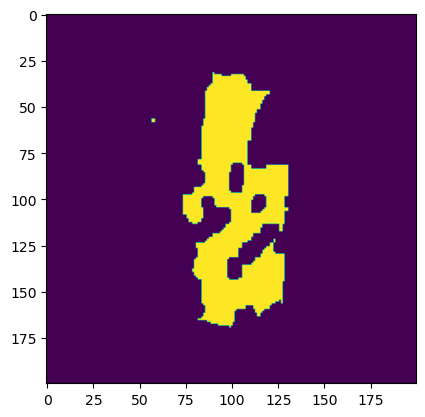

In [95]:
plt.imshow(walkable_mask)

In [96]:
entrance_point_candidates_row = np.where(walkable_mask==1)[0][-21:-1]
entrance_point_candidates_col = np.where(walkable_mask==1)[1][-21:-1]

In [97]:
start_point = (int(np.mean(entrance_point_candidates_row)), int(np.mean(entrance_point_candidates_col)))
start_point

(167, 95)

In [98]:
print(walkable_mask[start_point])

1


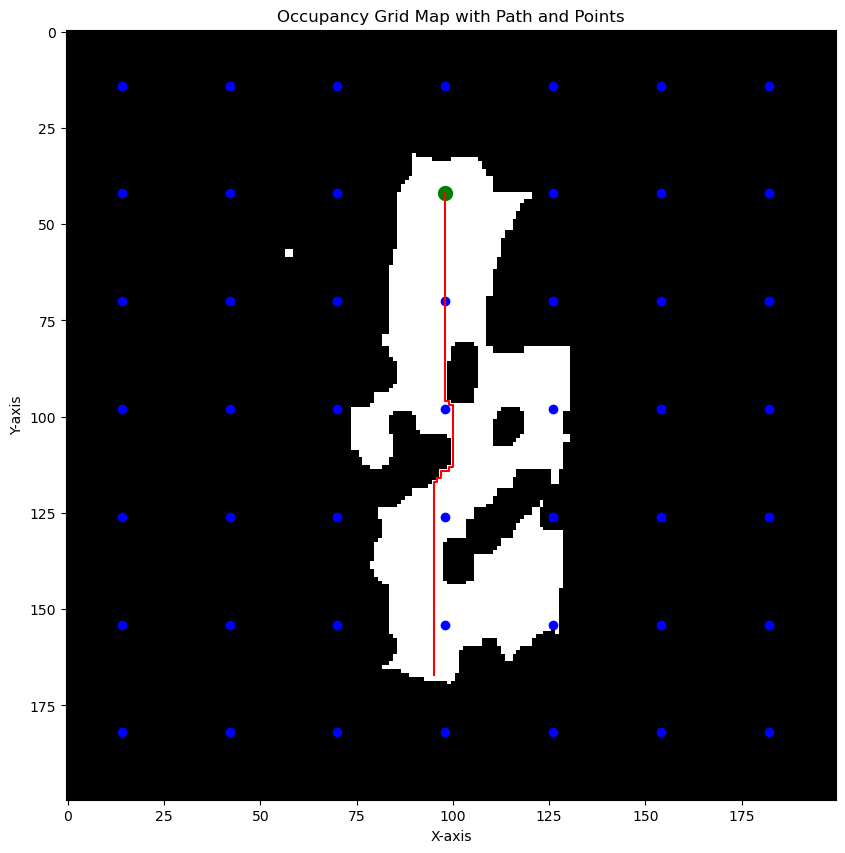

The best exit point is (42, 98) with a path length of 133.


In [99]:
size = (200, 200)
start = start_point

occupancy_grid = walkable_mask

# Ensure there is a path from start to goal
# ensure_path(occupancy_grid, start, goal)

# Generate 25 evenly distributed points
points = generate_evenly_distributed_points(size, 50)

# Evaluate the points to find the best exit point
best_exit_point, path_length = evaluate_exit_points(occupancy_grid, start, points)

# Visualize the grid and the path
if best_exit_point is not None:
    best_path = a_star(start, best_exit_point, occupancy_grid)
    visualize_grid(occupancy_grid, best_path, points, best_exit_point)
    print(f"The best exit point is {best_exit_point} with a path length of {path_length}.")
else:
    print("No valid exit point found.")

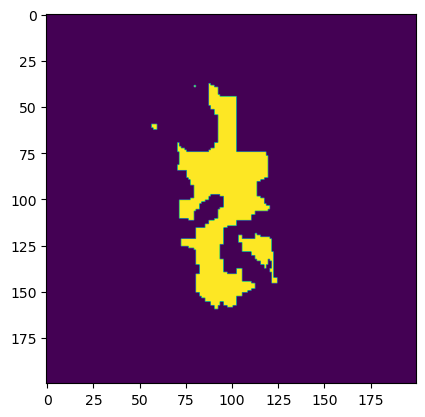

In [32]:
plt.imshow(occupancy_grid)